This notebook presents how to fit log Gaussian tuning curves to the data from the NSDsyn dataset. In this example, the data is first binned by eccentricity (0.5-1, 1-2, & 2-4 deg) and then averaged across stimulus classes. The tuning curves are fitted for each eccentricity bin. 

Related snakemake rules: `binning`, `fit_tuning_curves`

# Configurations

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures/sfp_model/results_1D/nsdsyn')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'

In [3]:
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
roi_list=['V1','V2','V3']
e1, e2=0.5, 4
enum= 'log3'
lr = 0.005
max_epoch = 8000
subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
subj='subj01'
roi='V1'
voxels='pRFcenter'

# Load betas and experimental design information

In [5]:
subj_df = pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'model', f'dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.csv'))
subj_df = subj_df.query('~names.str.contains("intermediate").values')


# 1. Binning

In [6]:
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, 'log3')
subj_df['ecc_bin'] = tuning.bin_ecc(subj_df['eccentricity'], bin_list, bin_labels)
#bin_df = subj_df.groupby(['sub','vroinames','ecc_bin','freq_lvl','names']).mean().reset_index()
bin_df = tuning.summary_stat_for_ecc_bin(subj_df,
                                       to_group=['sub','vroinames','ecc_bin','freq_lvl','names'],
                                       to_bin=['betas', 'local_sf'],
                                       central_tendency='mean')

## Sanity check: Datapoints only

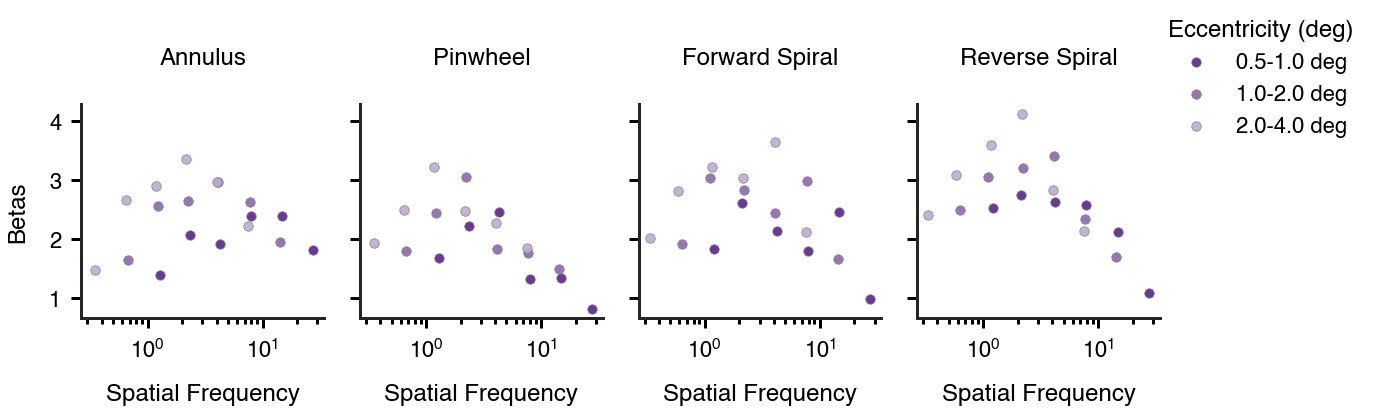

In [7]:
ecc_colors = utils.get_continuous_colors(len(bin_labels)+1, '#3f0377')
ecc_colors = ecc_colors[1:][::-1]
vis1D.plot_datapoints(bin_df, 'local_sf', 'betas', hue='ecc_bin', hue_order=bin_labels, 
                      col='names', col_order=stim_classes, 
                    height=6, aspect=0.7, lgd_title='Eccentricity (deg)',
                    palette=ecc_colors)

# 2. Fitting log Gaussian curves for every eccentricity bin

In [8]:
avg_bin_df = bin_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()


In [9]:
loss_history, model_history = pd.DataFrame({}), pd.DataFrame({})
for ecc_bin in avg_bin_df.ecc_bin.unique():
    print(f'{ecc_bin}')
    tmp = avg_bin_df.query('ecc_bin == @ecc_bin')
    my_model = tuning.LogGaussianTuningModel()
    my_dataset = tuning.LogGaussianTuningDataset(tmp['local_sf'], tmp['betas'])
    tmp_loss_history, tmp_model_history = tuning.fit_tuning_curves(my_model, my_dataset, 
                                                                   max_epoch=100, print_every=50, 
                                                                   learning_rate=0.01)
    tmp_model_history['ecc_bin'] = ecc_bin
    tmp_loss_history['ecc_bin'] = ecc_bin
    model_history = pd.concat((model_history, tmp_model_history), axis=0)
    loss_history = pd.concat((loss_history, tmp_loss_history), axis=0)


0.5-1.0 deg
**epoch no.0 loss: 3.88222
**epoch no.49 loss: 2.59849
**epoch no.99 loss: 1.15669
**epoch no.100: Finished! final params {'slope': 2.076, 'mode': 1.692, 'sigma': 1.587}
Elapsed time: 0.07 sec 

1.0-2.0 deg
**epoch no.0 loss: 5.89247
**epoch no.49 loss: 4.49853
**epoch no.99 loss: 2.53081
**epoch no.100: Finished! final params {'slope': 1.18, 'mode': 2.434, 'sigma': 1.775}
Elapsed time: 0.05 sec 

2.0-4.0 deg
**epoch no.0 loss: 6.61654
**epoch no.49 loss: 4.48473
**epoch no.99 loss: 2.4692
**epoch no.100: Finished! final params {'slope': 1.529, 'mode': 1.371, 'sigma': 1.991}
Elapsed time: 0.05 sec 


# 3. Plotting the results

## 3.1. loss and model history checks 

In [103]:
args = ['class', 'lr', 'eph', 'dset', 'sub', 'roi', 'curbin']
l, m = [], []
for curbin, subj in itertools.product([0,1,2], subj_list):
    loss_file_name = f'loss-history_class-avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.h5'
    model_file_name =f'model-history_class-avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.h5'
    l.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', loss_file_name))
    m.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', model_file_name))


In [104]:
loss_df = utils.load_dataframes(l, *args)
model_df = utils.load_dataframes(m, *args)

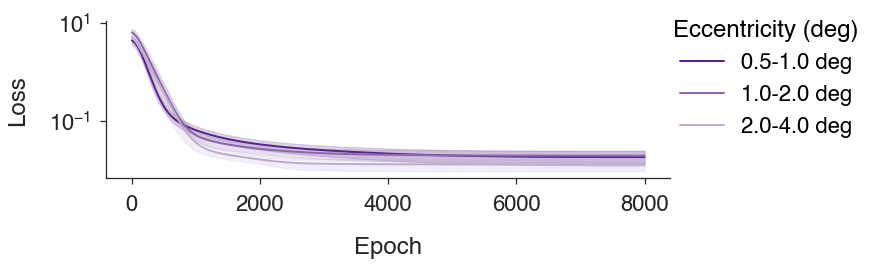

In [153]:
vis.plot_loss_history(loss_df[loss_df['epoch'] % 3 != 0], 
                      hue='ecc_bin', hue_order=bin_labels, 
                      lgd_title='Eccentricity (deg)', 
                      log_y=True, palette=ecc_colors, errorbar='se')

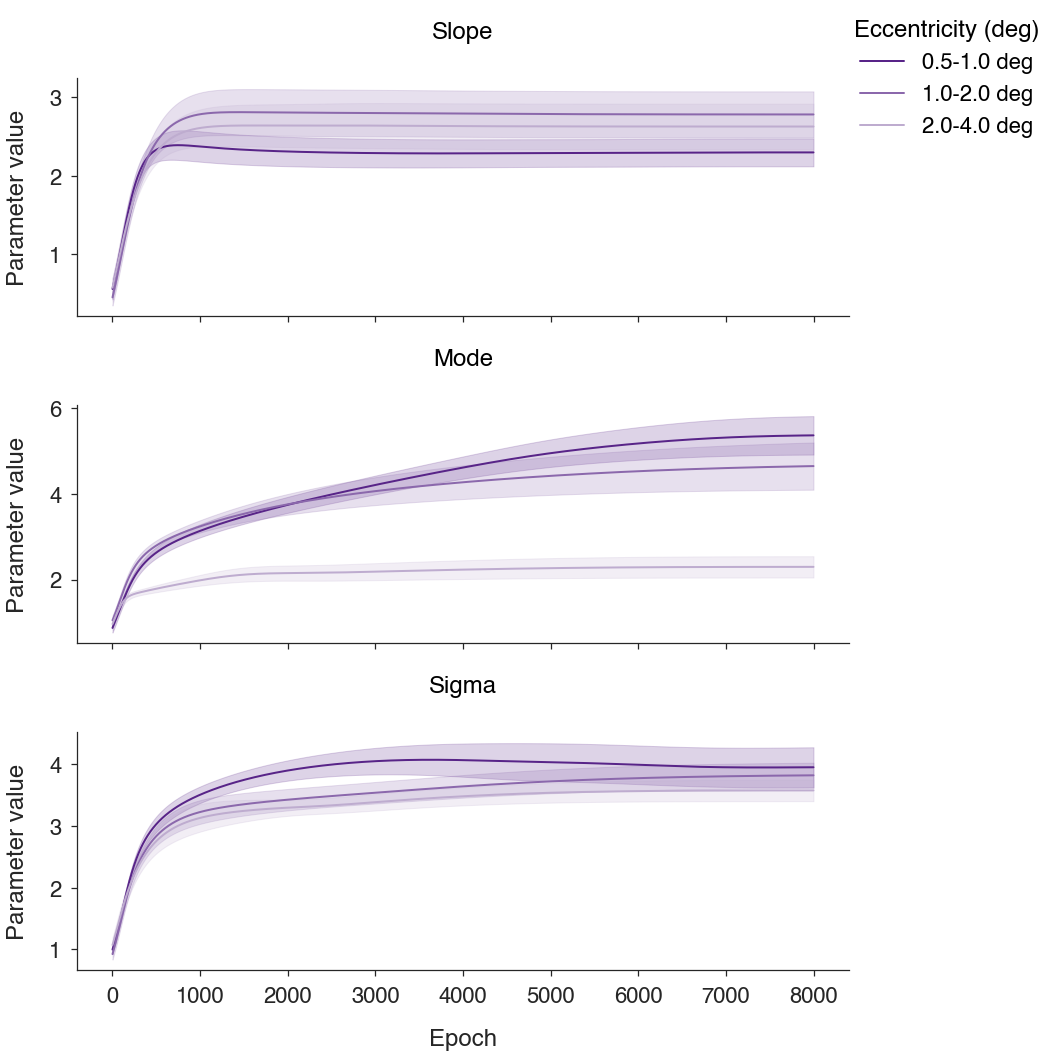

In [154]:
vis.plot_param_history(model_df[loss_df['epoch'] % 3 != 0], params=['slope','mode','sigma'],
                       hue='ecc_bin', hue_order=bin_labels, 
                       lgd_title='Eccentricity (deg)', errorbar='se',
                       palette=ecc_colors)

## 3.2 Tuning curves

### Load the data and the model

In [7]:

f, m = [], []
for subj, roi in itertools.product(subj_list, roi_list):
    file_name = f'e1-{e1}_e2-{e2}_nbin-log3_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'binned', file_name))

subj_df = utils.load_dataframes(f)
subj_df = subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

In [8]:
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']

pt_file_list = []
for subj, roi, curbin in itertools.product(subj_list, roi_list, [0,1,2]):
    file_name = f'model-params_class-avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-log3_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

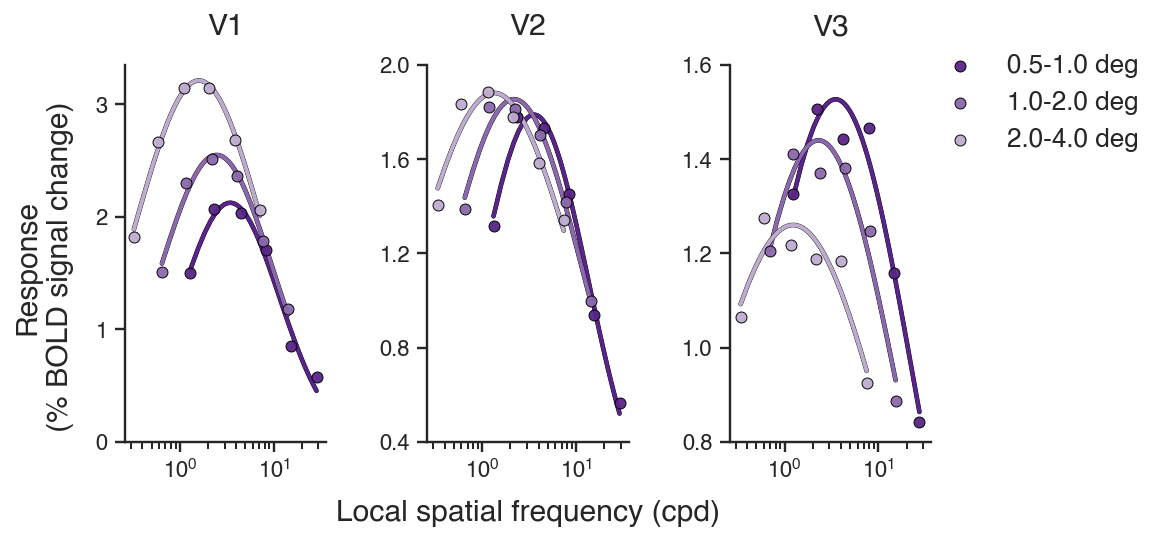

In [522]:
tmp_subj_df = subj_df.query('sub == "subj06"')
tmp_tuning_df = tuning_df.query('sub == "subj06"')
fig_name = os.path.join(output_dir,"figures", "sfp_model","results_1D", "nsdsyn", f'tuning_class_avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-log3_curbin-all_dset-nsdsyn_sub-subj06_roi-all_vs-pRFsize.pdf')
vis1D.plot_sf_curves(df=tmp_subj_df, x='local_sf', y='betas', hue='ecc_bin',
                     col='vroinames', params_df=tmp_tuning_df, lgd_title=None,
                     save_path=fig_name)

## 3.3 Preferred period as function of eccentricity

We plot preferred period as a function of eccentricity averaged across subjects. 
To calculate the average, we use precision as weights for each subject. 

### Load precision for each subject

In [9]:
file_list = []
for subj, roi in itertools.product(subj_list, ['V1','V2','V3']):
    f = os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision', 
                     f'precision-v_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
    
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

In [10]:
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
enum='log3'
pt_file_list = []
for subj, roi, curbin in itertools.product(subj_list, roi_list, np.arange(0, 3)):
    file_name = f'model-params_class-avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

In [14]:
tuning_with_precision_df = tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
tuning_with_precision_df['pp'] = 1/ tuning_with_precision_df['mode']
fit_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'pp', 'precision', groupby=['vroinames'])

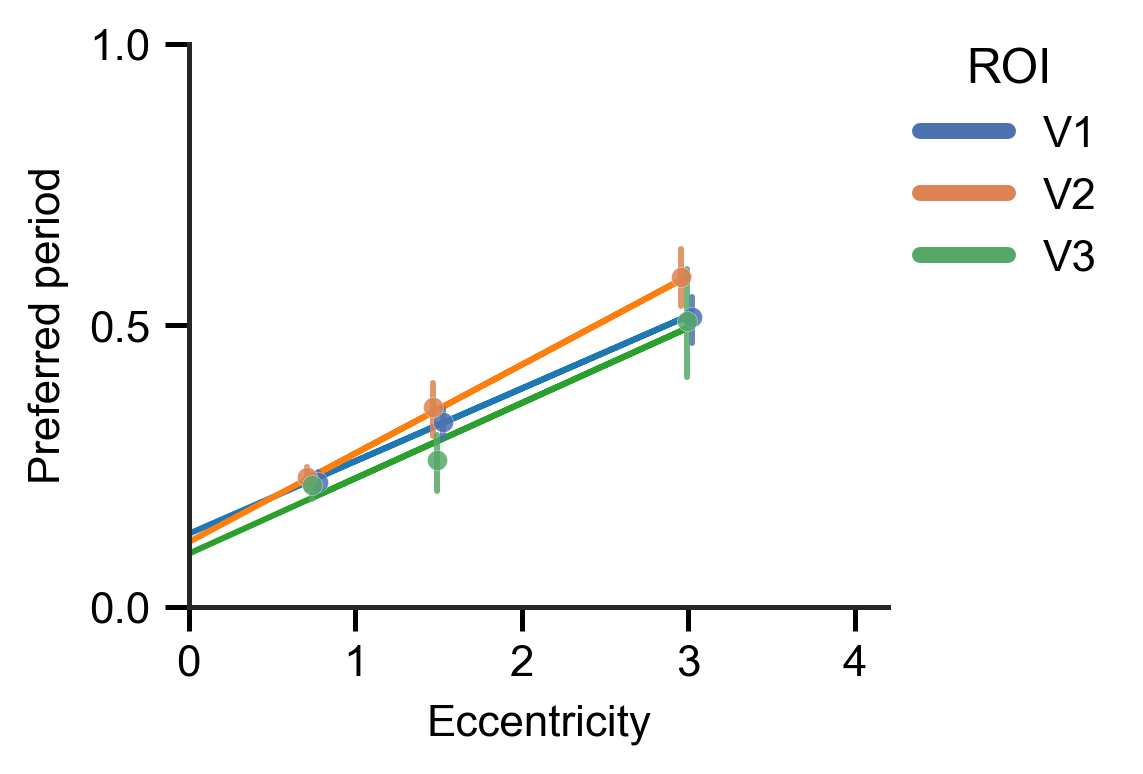

In [16]:
g = vis1D.plot_preferred_period(tuning_with_precision_df, 
                                preferred_period='pp', precision='precision', hue='vroinames', 
                                hue_order=['V1','V2','V3'], fit_df=fit_df, lgd_title='ROI',
                                save_path=os.path.join(fig_dir, f'preferred_period_avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-log3_dset-nsdsyn_vs-{voxels}.pdf'))


# Each stimulus class's preferred period as a function of eccentricity

In [430]:
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']

pt_file_list = []
for subj, roi, curbin in itertools.product(subj_list, roi_list, np.arange(0, 3)):
    for stim_class in stim_classes:
        stim_class = stim_class.replace(' ', '-')
        file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
        pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

In [431]:
tuning_with_precision_df = tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
fit_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'mode', 'precision', groupby=['vroinames','names'])

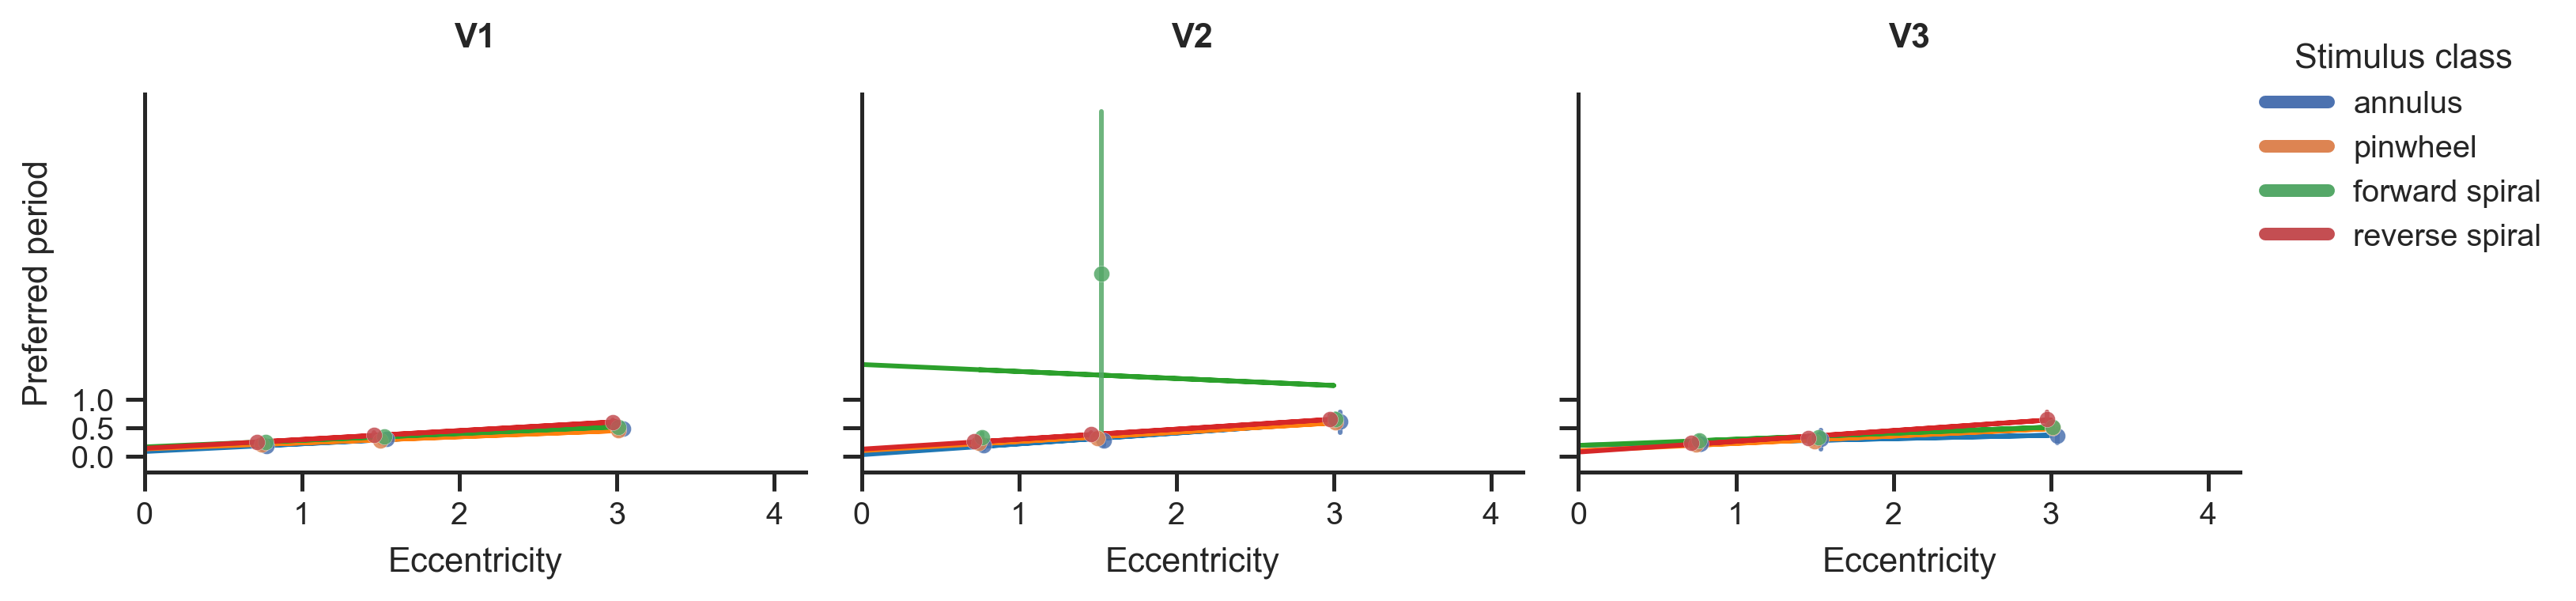

In [432]:
g = vis1D.plot_preferred_period(tuning_with_precision_df, col='vroinames', col_order=roi_list,
                                sf_peak='mode', precision='precision', hue='names', width=7,
                                hue_order=stim_classes, fit_df=fit_df, lgd_title='Stimulus class')

,slope,mode,sigma,sub,names,dset,lr_rate,max_epoch,vroinames,e1,e2,nbin,curbin,ecc_bin,precision,ecc,pp
18,2.253163,4.858312,5.665891,subj01,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,1.548457,1.5,0.205833
54,2.173597,0.039047,8.928065,subj02,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.881836,1.5,25.609896
90,2.940261,6.501976,4.422491,subj03,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.748543,1.5,0.153799
126,2.078771,5.209052,6.341847,subj04,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.872796,1.5,0.191974
162,3.303940,2.230087,3.844835,subj05,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.737055,1.5,0.448413
198,1.595648,2.169053,2.837367,subj06,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,1.866259,1.5,0.461031
234,4.036446,2.548296,3.419777,subj07,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.585363,1.5,0.392419
270,3.146333,0.849075,5.066793,subj08,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.637120,1.5,1.177752


<AxesSubplot:xlabel='precision', ylabel='pp'>

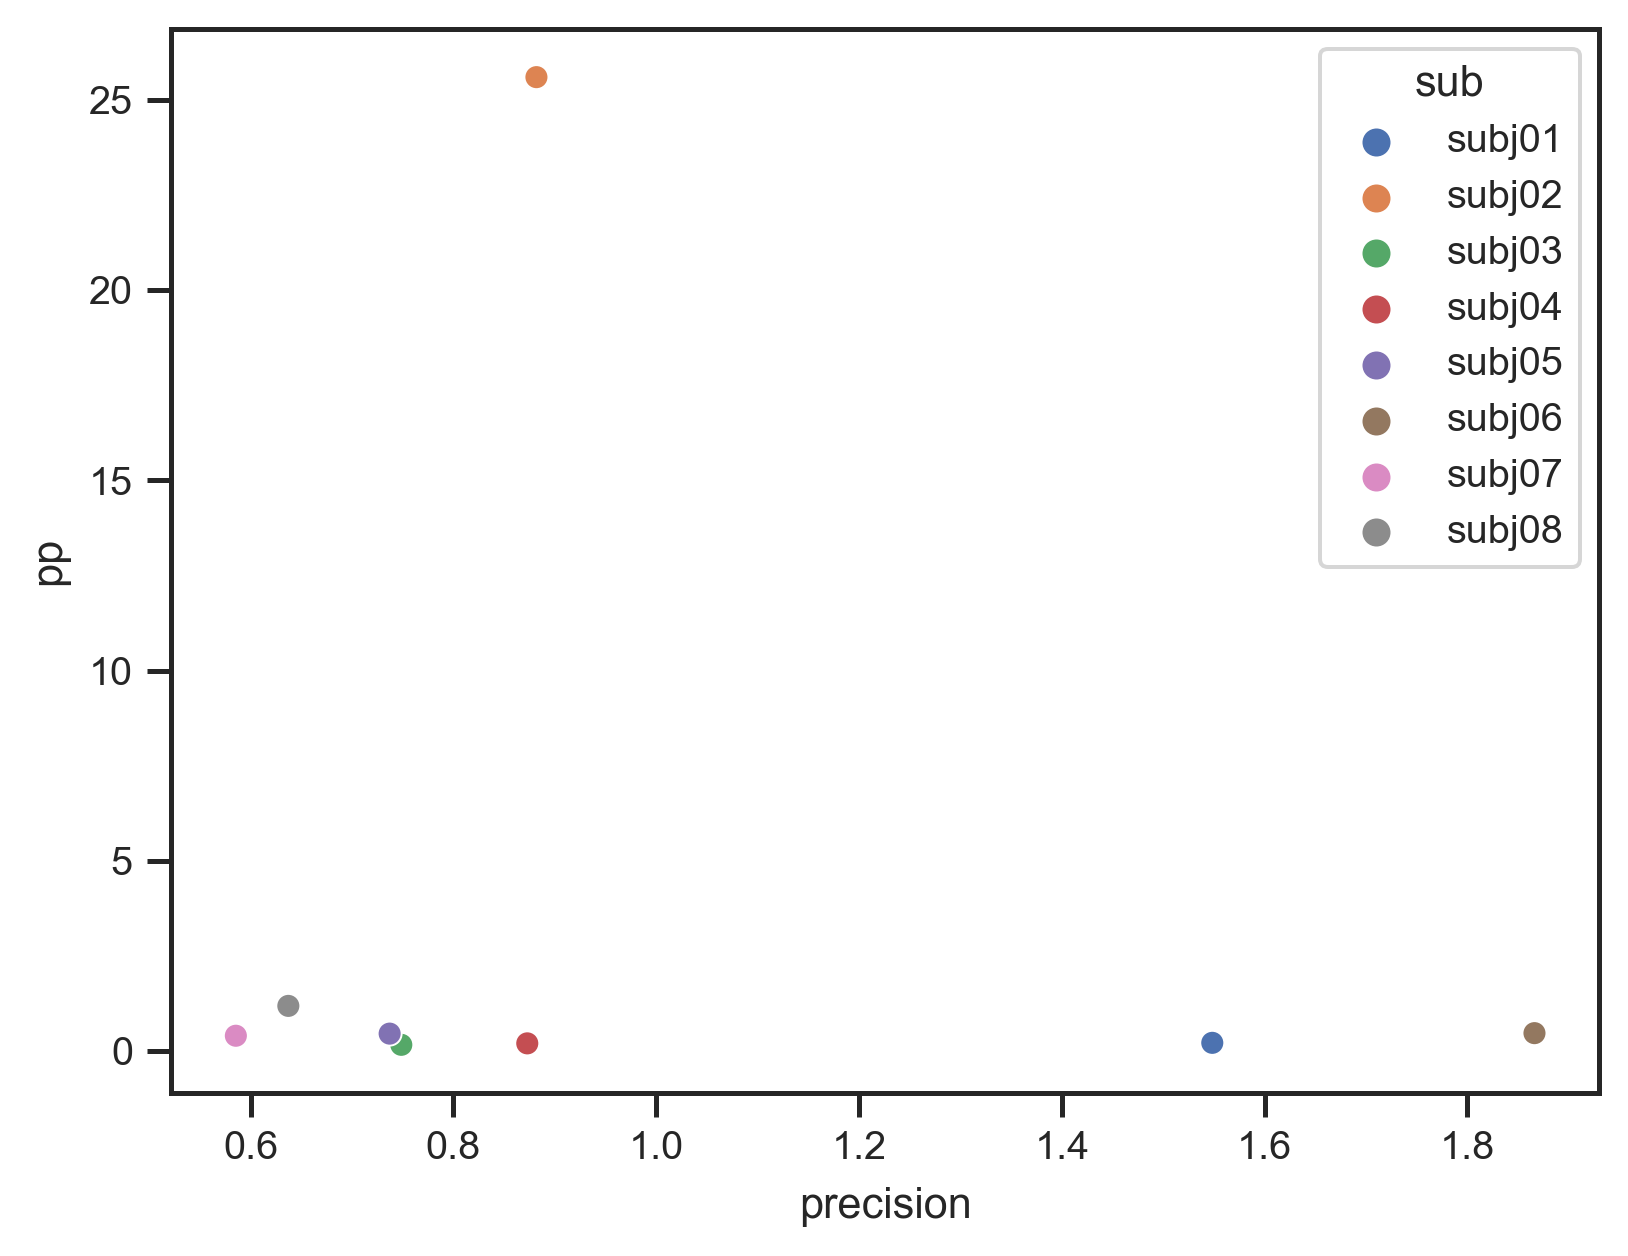

In [439]:
test = tuning_with_precision_df.query('vroinames == "V2" & names == "forward spiral" & curbin == "1"')
sns.scatterplot(data=test, x='precision', y='pp', hue='sub')

# Baseline? 

In [568]:
example_subj = 'subj04'
tmp_df = subj_df.query('sub == @example_subj & vroinames == "V1" & ecc_bin == @bin_labels[0]')
params_tmp_df = tuning_df.query('sub == @example_subj & vroinames == "V1" & ecc_bin == @bin_labels[0]')

,slope,mode,sigma,sub,names,dset,lr_rate,max_epoch,vroinames,e1,e2,nbin,curbin,ecc_bin
0,2.373721,3.950246,2.557054,subj01,avg,nsdsyn,0.005,8000,V1,0.5,4,log3,0,0.5-1.0 deg
0,2.937244,2.571746,2.372591,subj01,avg,nsdsyn,0.005,8000,V1,0.5,4,log3,1,1.0-2.0 deg
0,3.347748,1.686050,2.253984,subj01,avg,nsdsyn,0.005,8000,V1,0.5,4,log3,2,2.0-4.0 deg
0,2.078254,4.495413,3.870455,subj01,avg,nsdsyn,0.005,8000,V2,0.5,4,log3,0,0.5-1.0 deg
0,2.232673,3.660676,4.095217,subj01,avg,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2.921265,3.275620,3.640059,subj08,avg,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg
0,2.994702,1.855636,3.149396,subj08,avg,nsdsyn,0.005,8000,V2,0.5,4,log3,2,2.0-4.0 deg
0,1.878122,6.792418,3.676619,subj08,avg,nsdsyn,0.005,8000,V3,0.5,4,log3,0,0.5-1.0 deg
0,2.701339,6.135540,3.864834,subj08,avg,nsdsyn,0.005,8000,V3,0.5,4,log3,1,1.0-2.0 deg


In [109]:

tmp_subj_df = subj_df.query('sub == @example_subj & vroinames == @roi & ecc_bin == @b')
params_tmp_df = tuning_df.query('sub == @example_subj & vroinames == @roi & ecc_bin == @b')
# find the half of the peak based on the lowest beta value in the prediction
results_half_y = params_tmp_df['slope'].item()/2
pred_x, pred_y = tuning._get_x_and_y_prediction(0, 
                                                tmp_subj_df['local_sf'].max(),  
                                                params_tmp_df['slope'].item(), 
                                                params_tmp_df['mode'].item(), 
                                                params_tmp_df['sigma'].item(), n_points=10)
# find the x values that are the closest to the half of the peak
[k-results_half_y for k in pred_y]

#half_y = abs(pred_y - results_half_y)
#half_y
# results_half_x_min = results_half_x[pred_x[results_half_x] < peak]
# f_low = pred_x[results_half_x_min][0]
# 
# results_half_x_max = results_half_x[pred_x[results_half_x] > peak]
# f_high = pred_x[results_half_x_max][0]
# # Calculate the bandwidth in octave
# fwhm_octaves = np.log2(f_high) - np.log2(f_low)

[0.7007293292678194,
 1.07800804268859,
 1.1087525522799853,
 1.0785681042955813,
 1.0314617987611343,
 0.9799197132450725,
 0.9283556779328097,
 0.8784627873734927,
 0.8308691883007726,
 0.7857494829697764]

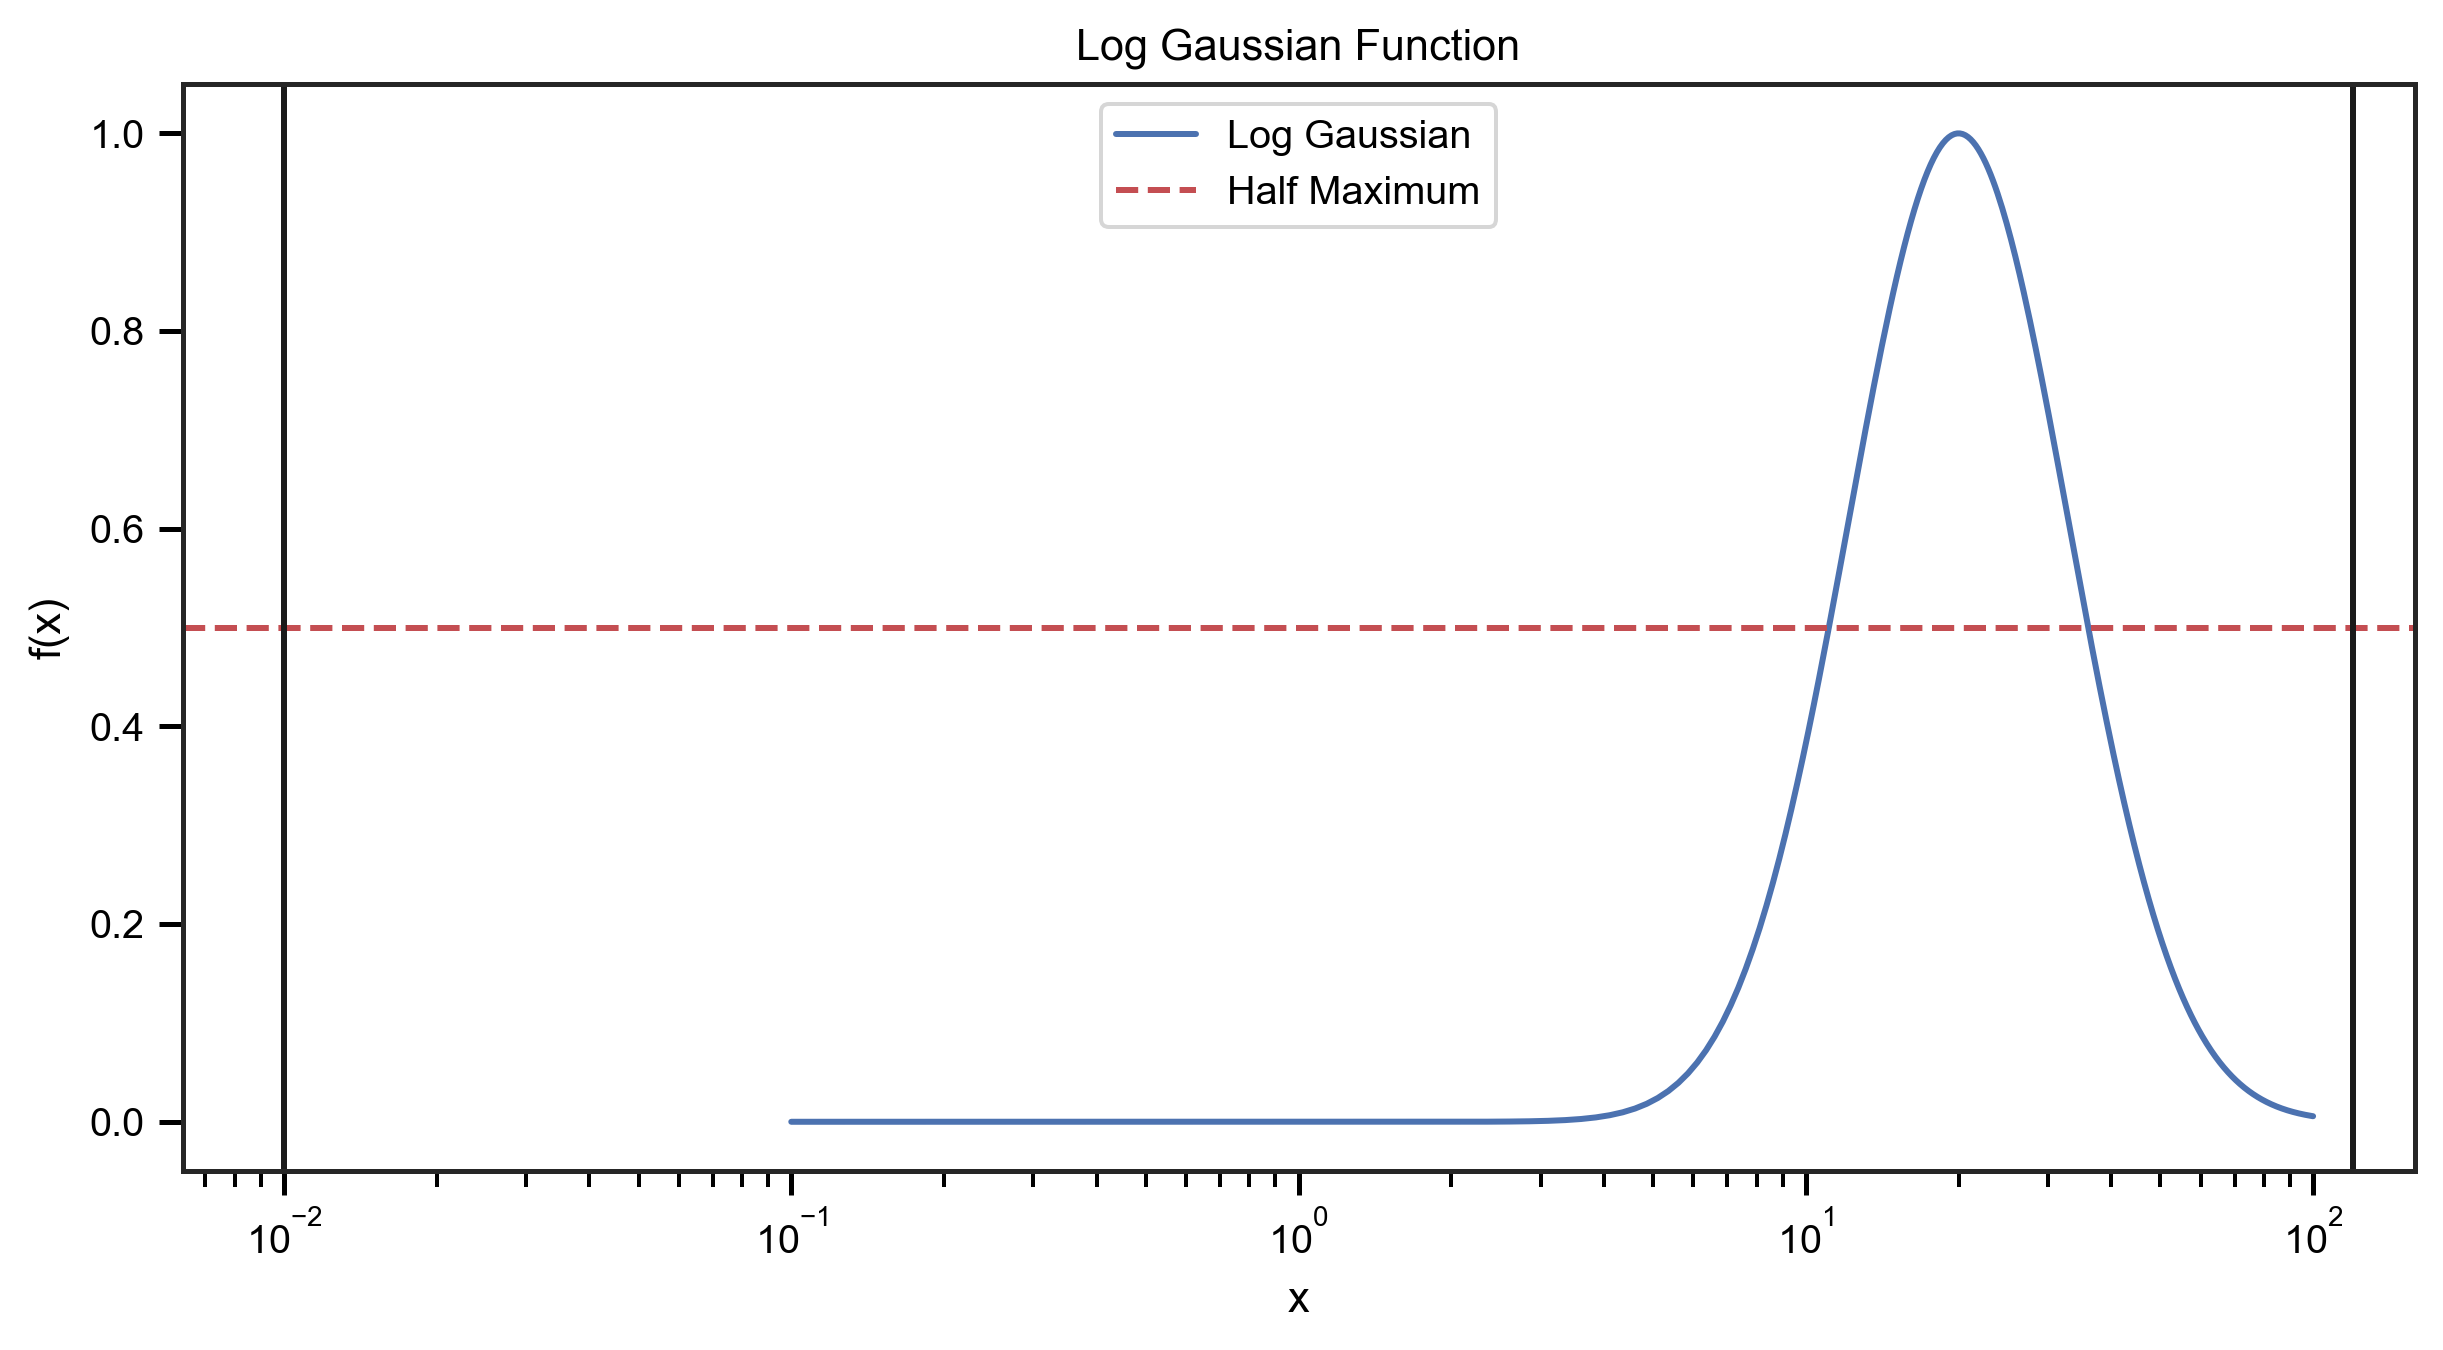

In [156]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 20
sigma = 0.5

# Define the log Gaussian function
def log_gaussian(x, mu, sigma):
    return np.exp(-((np.log(x) - np.log(mu)) ** 2) / (2 * sigma ** 2))

x_values = np.linspace(0.1, 100, 400)
y_values = log_gaussian(x_values, mu, sigma)
x_min, x_max = 1e-2, np.ceil(mu + 10**2)

plt.figure(figsize=(10, 5))
plt.plot(x_values, y_values, label='Log Gaussian')
plt.axhline(y=np.max(y_values) / 2, color='r', linestyle='--', label='Half Maximum')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.xscale('log')
plt.axvline(x_min, c='k')
plt.axvline(x_max, c='k')
plt.title('Log Gaussian Function')
plt.show()


In [160]:
pred_x, pred_y = tuning._get_x_and_y_prediction(1e-3, 
                                                10**3,  
                                                1, 
                                                mu, 
                                                sigma, n_points=10000)
# find the x values that are the closest to the half of the peak
results_half_y = [k-results_half_y for k in pred_y]

results_half_y
# results_half_x_min = results_half_x[pred_x[results_half_x] < peak]
# f_low = pred_x[results_half_x_min][0]
# 
# results_half_x_max = results_half_x[pred_x[results_half_x] > peak]
# f_high = pred_x[results_half_x_max][0]
# # Calculate the bandwidth in octave
# fwhm_octaves = np.log2(f_high) - np.log2(f_low)

KeyboardInterrupt: 

In [143]:
tuning.get_bandwidth_chatgpt(20, 0.5, 1)

x1 (lower half-max point): [11.10091195]
x2 (upper half-max point): [36.03307565]
FWHM in octaves: [1.6986436]


In [183]:
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, 'log3')
bandwidth_df = pd.DataFrame({})

for example_subj, b, roi in itertools.product(subj_list, bin_labels, roi_list):
    print(example_subj)
    tmp_subj_df = subj_df.query('sub == @example_subj & vroinames == @roi & ecc_bin == @b')
    params_tmp_df = tuning_df.query('sub == @example_subj & vroinames == @roi & ecc_bin == @b')
    bandwidth = tuning.get_bandwidth_chatgpt(params_tmp_df['mode'].item(), 
                                             params_tmp_df['sigma'].item(), 
                                             params_tmp_df['slope'].item())


    tmp_df = pd.DataFrame({})    
    tmp_df['sub'] = [example_subj]
    tmp_df['vroinames'] = [roi]
    tmp_df['ecc_bin'] = [b]
    tmp_df['bandwidth'] = bandwidth
    bandwidth_df = pd.concat((bandwidth_df, tmp_df), axis=0)

subj01
x1 (lower half-max point): [0.19457792]
x2 (upper half-max point): [80.19638481]
FWHM in octaves: [8.68704535]
subj01
x1 (lower half-max point): [0.04716727]
x2 (upper half-max point): [428.44828617]
FWHM in octaves: [13.14904732]
subj01
x1 (lower half-max point): [0.03776729]
x2 (upper half-max point): [415.35836883]
FWHM in octaves: [13.42493176]
subj01
x1 (lower half-max point): [0.15740586]
x2 (upper half-max point): [42.01798419]
FWHM in octaves: [8.06037391]
subj01
x1 (lower half-max point): [0.02947827]
x2 (upper half-max point): [454.59075467]
FWHM in octaves: [13.91262907]
subj01
x1 (lower half-max point): [0.02563198]
x2 (upper half-max point): [1029.71099101]
FWHM in octaves: [15.29393527]
subj01
x1 (lower half-max point): [0.11866211]
x2 (upper half-max point): [23.95679526]
FWHM in octaves: [7.65743172]
subj01
x1 (lower half-max point): [0.03483463]
x2 (upper half-max point): [116.05942531]
FWHM in octaves: [11.70205367]
subj01
x1 (lower half-max point): [0.0178693]

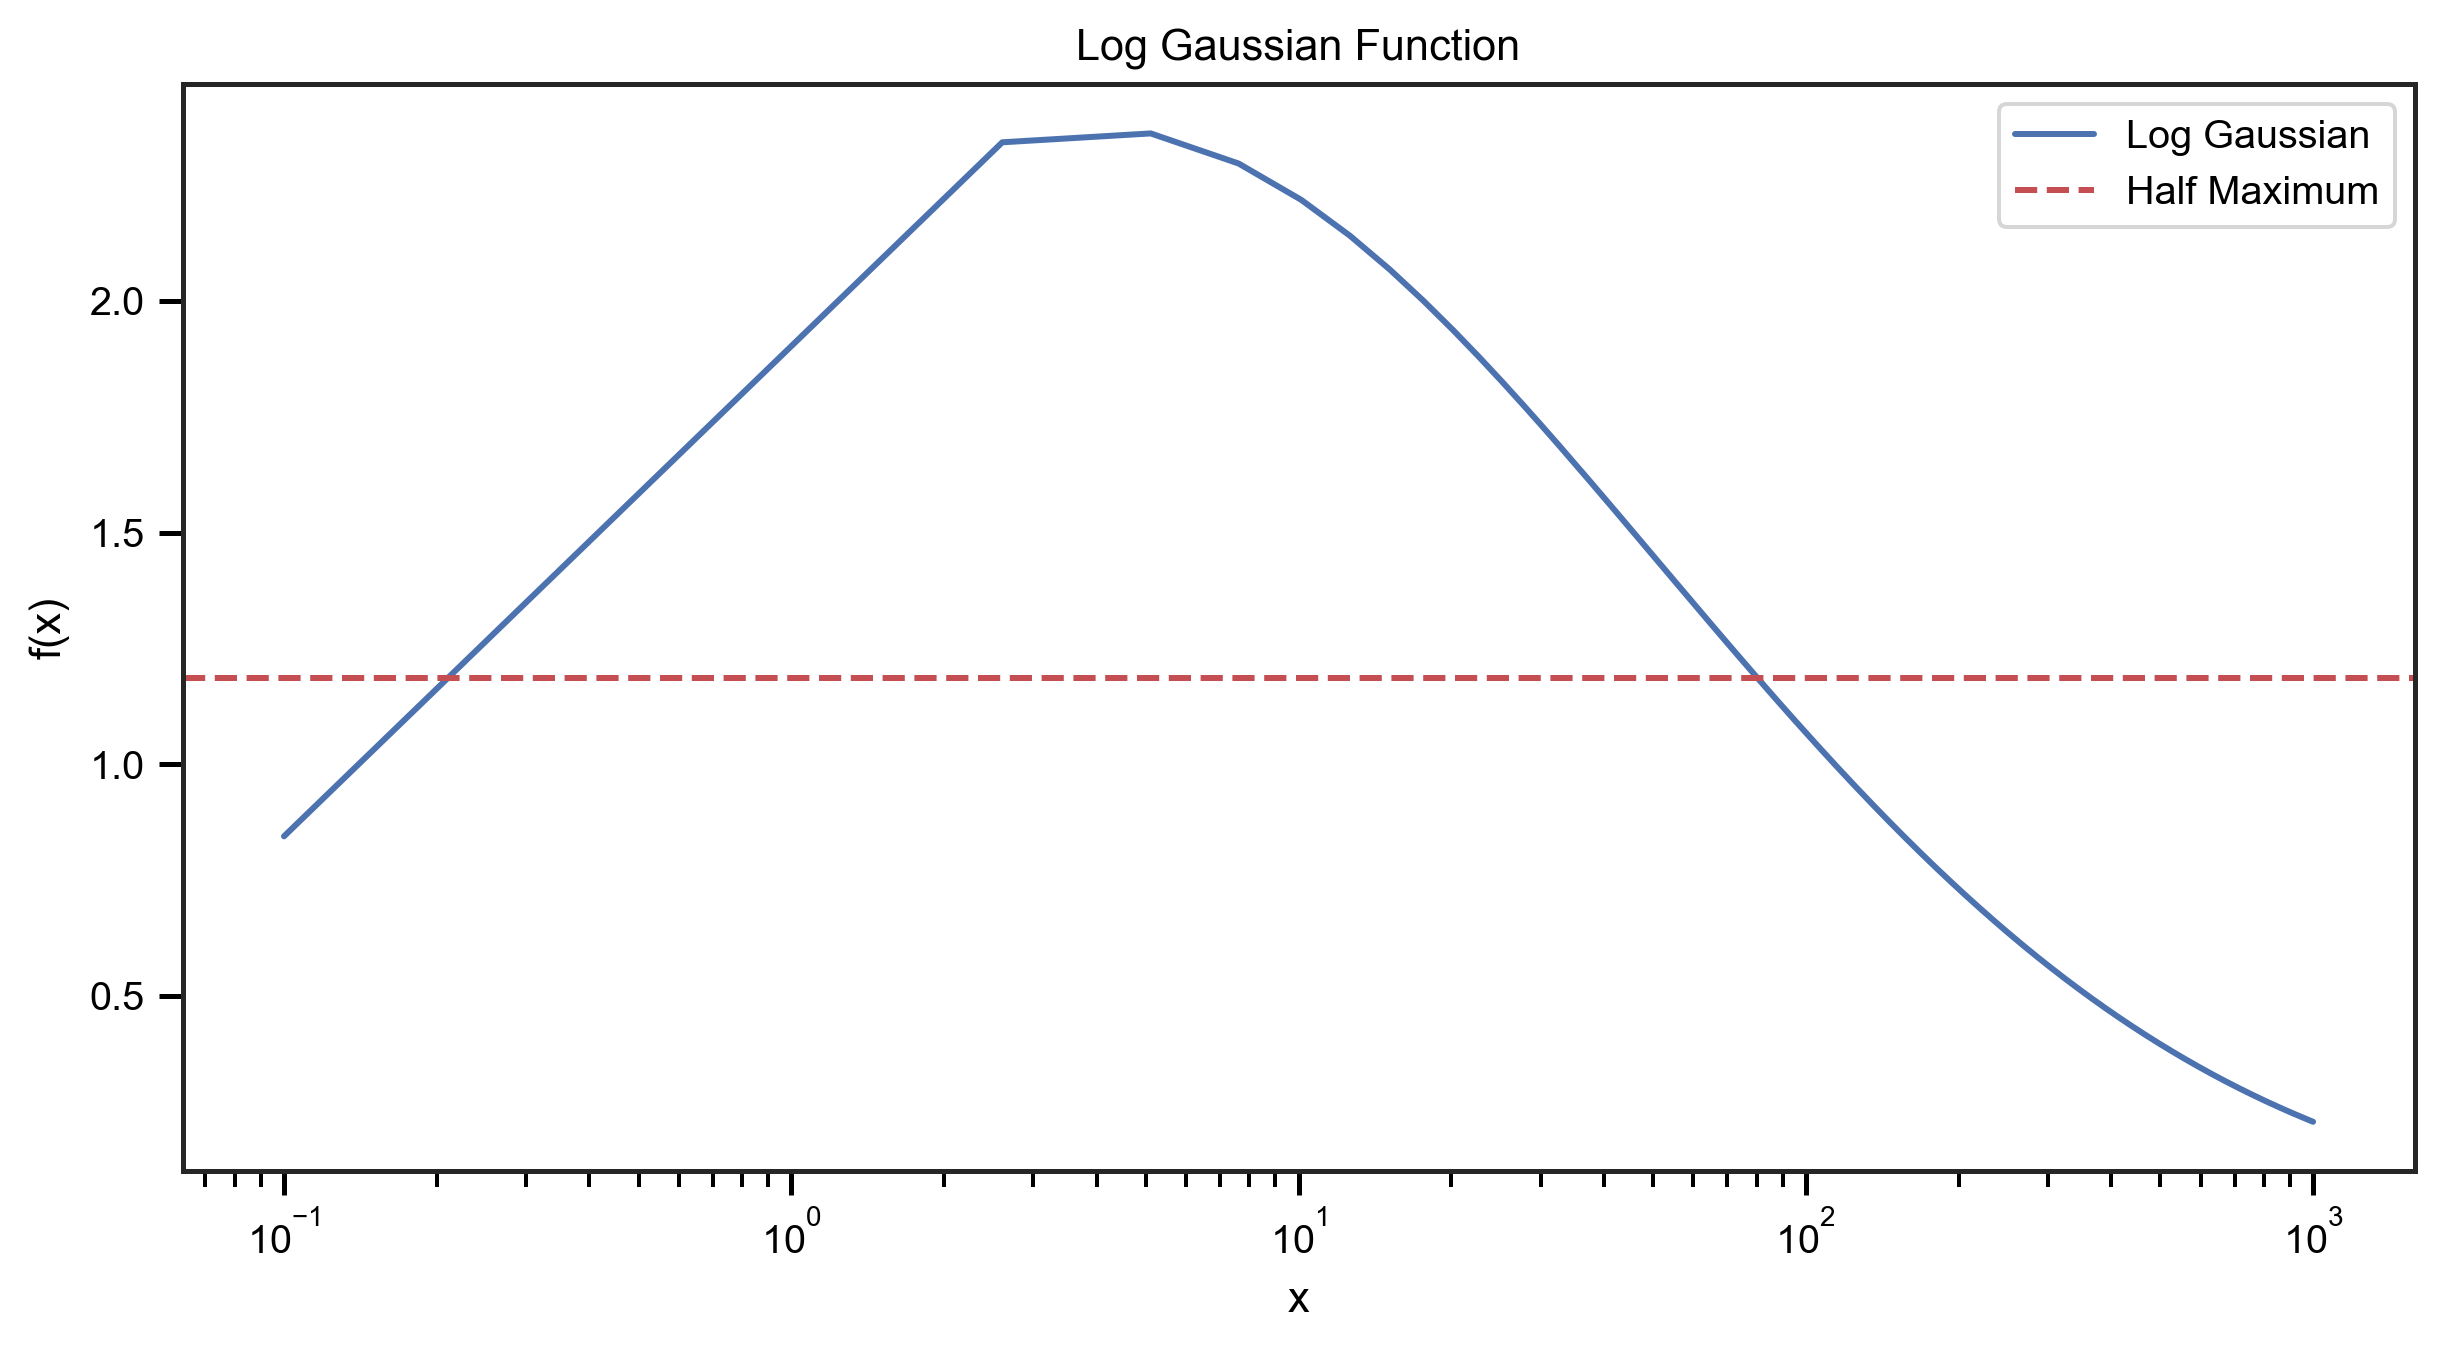

In [177]:

# Define the log Gaussian function
def log_gaussian(x, A, mu, sigma):
    return A*np.exp(-((np.log(x) - np.log(mu)) ** 2) / (2 * sigma ** 2))

x_values = np.linspace(0.1, 1000, 400)
example_subj='subj01'
params_tmp_df = tuning_df.query('sub == @example_subj & vroinames == @roi & ecc_bin == @b')
A = params_tmp_df['slope'].item()
mu = params_tmp_df['mode'].item()
sigma = params_tmp_df['sigma'].item()
y_values = log_gaussian(x_values, A, mu, sigma)

plt.figure(figsize=(10, 5))
plt.plot(x_values, y_values, label='Log Gaussian')
plt.axhline(y=0.5*A, color='r', linestyle='--', label='Half Maximum')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.xscale('log')
plt.title('Log Gaussian Function')
plt.show()

In [88]:
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, 'log3')
bandwidth_df = pd.DataFrame({})

for example_subj, b, roi in itertools.product(subj_list[:3], bin_labels[:1], roi_list[2:3]):
    print(example_subj)
    tmp_subj_df = subj_df.query('sub == @example_subj & vroinames == @roi & ecc_bin == @b')
    params_tmp_df = tuning_df.query('sub == @example_subj & vroinames == @roi & ecc_bin == @b')
    tuning.get_bandwidth_chatgpt(params_tmp_df['mode'].item(), params_tmp_df['sigma'].item(), params_tmp_df['slope'].item())


subj01
x1 (lower half-max point): 0.3960676670074463
x2 (upper half-max point): 415.3583688288655
FWHM in octaves: 10.034393975846475
subj02
x1 (lower half-max point): 0.5213469982147216
x2 (upper half-max point): 1447.054859528434
FWHM in octaves: 11.438588075312408
subj03
x1 (lower half-max point): 0.6626273632049561
x2 (upper half-max point): 526.3601212479451
FWHM in octaves: 9.633636693856227


/Users/jh7685/Documents/Projects/spatial-frequency-preferences_NSDsyn/sfp_nsdsyn/one_dimensional_model.py:634: RuntimeWarning: invalid value encountered in log
  f_high = pred_x[results_half_x_max][0]


In [68]:
params_tmp_df

,slope,mode,sigma,sub,names,dset,lr_rate,max_epoch,vroinames,e1,e2,nbin,curbin,ecc_bin
0,1.878122,6.792418,3.676619,subj08,avg,nsdsyn,0.005,8000,V3,0.5,4,log3,0,0.5-1.0 deg


In [184]:
bandwidth_df = bandwidth_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])

In [185]:
bandwidth_df.query('vroinames == "V3"')

,sub,vroinames,ecc_bin,bandwidth,precision
6,subj01,V3,0.5-1.0 deg,13.424932,2.596731
7,subj01,V3,1.0-2.0 deg,15.293935,2.596731
8,subj01,V3,2.0-4.0 deg,14.950154,2.596731
15,subj02,V3,0.5-1.0 deg,16.233320,1.366474
16,subj02,V3,1.0-2.0 deg,14.701058,1.366474
17,subj02,V3,2.0-4.0 deg,10.104069,1.366474
24,subj03,V3,0.5-1.0 deg,12.623417,1.522384
25,subj03,V3,1.0-2.0 deg,12.361107,1.522384
26,subj03,V3,2.0-4.0 deg,11.934889,1.522384
33,subj04,V3,0.5-1.0 deg,10.080089,0.781527


In [186]:
fit_df = vis1D.fit_line_to_weighted_mean(bandwidth_df, 'bandwidth', 'precision', groupby=['vroinames'])

In [187]:
fit_df

,vroinames,ecc,weighted_mean,coefficient,fitted
0,V1,0.75,7.852734,"[-0.05888121202028619, 7.885649573714285]",7.841489
1,V1,1.50,7.780459,"[-0.05888121202028619, 7.885649573714285]",7.797328
2,V1,3.00,7.714629,"[-0.05888121202028619, 7.885649573714285]",7.709006
3,V2,0.75,10.864325,"[-0.4832986236804799, 11.608122954601681]",11.245649
4,V2,1.50,11.455162,"[-0.4832986236804799, 11.608122954601681]",10.883175
5,V2,3.00,9.967565,"[-0.4832986236804799, 11.608122954601681]",10.158227
6,V3,0.75,12.848871,"[-0.21043851746443132, 13.081100583614159]",12.923272
7,V3,1.50,12.877044,"[-0.21043851746443132, 13.081100583614159]",12.765443
8,V3,3.00,12.412585,"[-0.21043851746443132, 13.081100583614159]",12.449785
0,V1,0.00,7.852734,"[-0.05888121202028619, 7.885649573714285]",7.885650


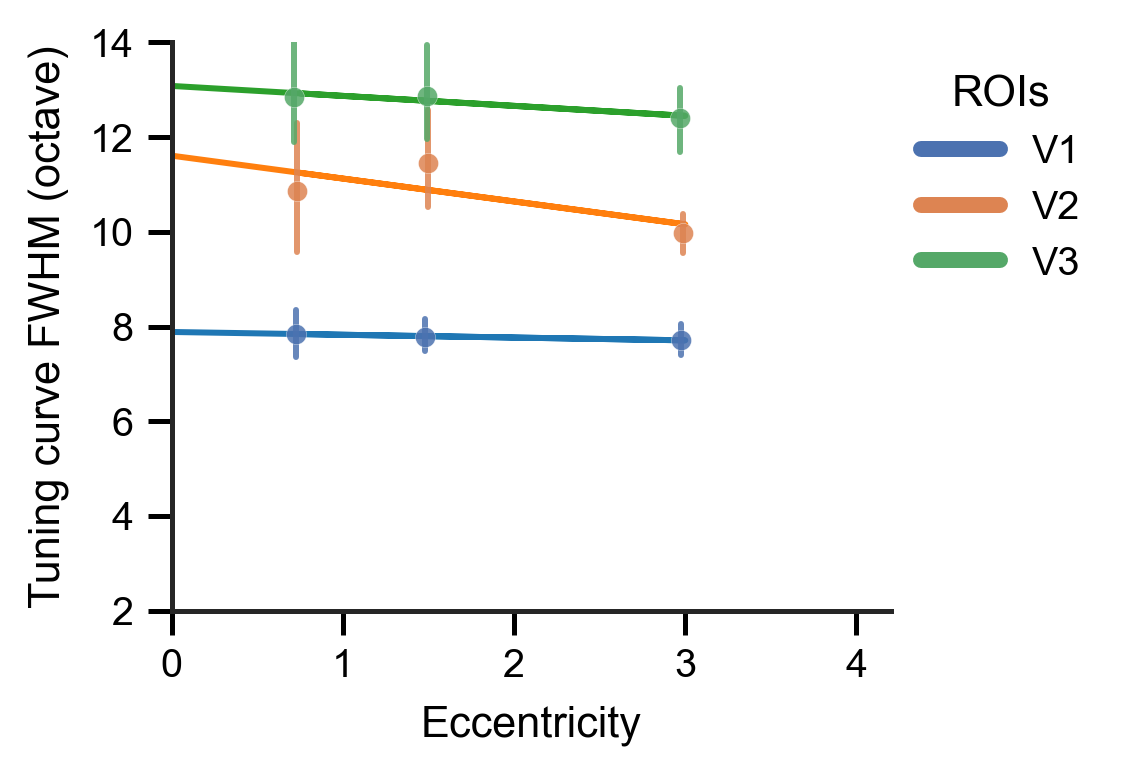

In [191]:
vis1D.plot_bandwidth_in_octave(bandwidth_df, 'bandwidth', 'precision', 'vroinames', roi_list, fit_df=fit_df,
                              pal=sns.color_palette("tab10"),
                              lgd_title='ROIs',
                              col=None, col_order=None,
                              suptitle=None, width=3.25, errorbar=("ci", 68),
                              save_path=None)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

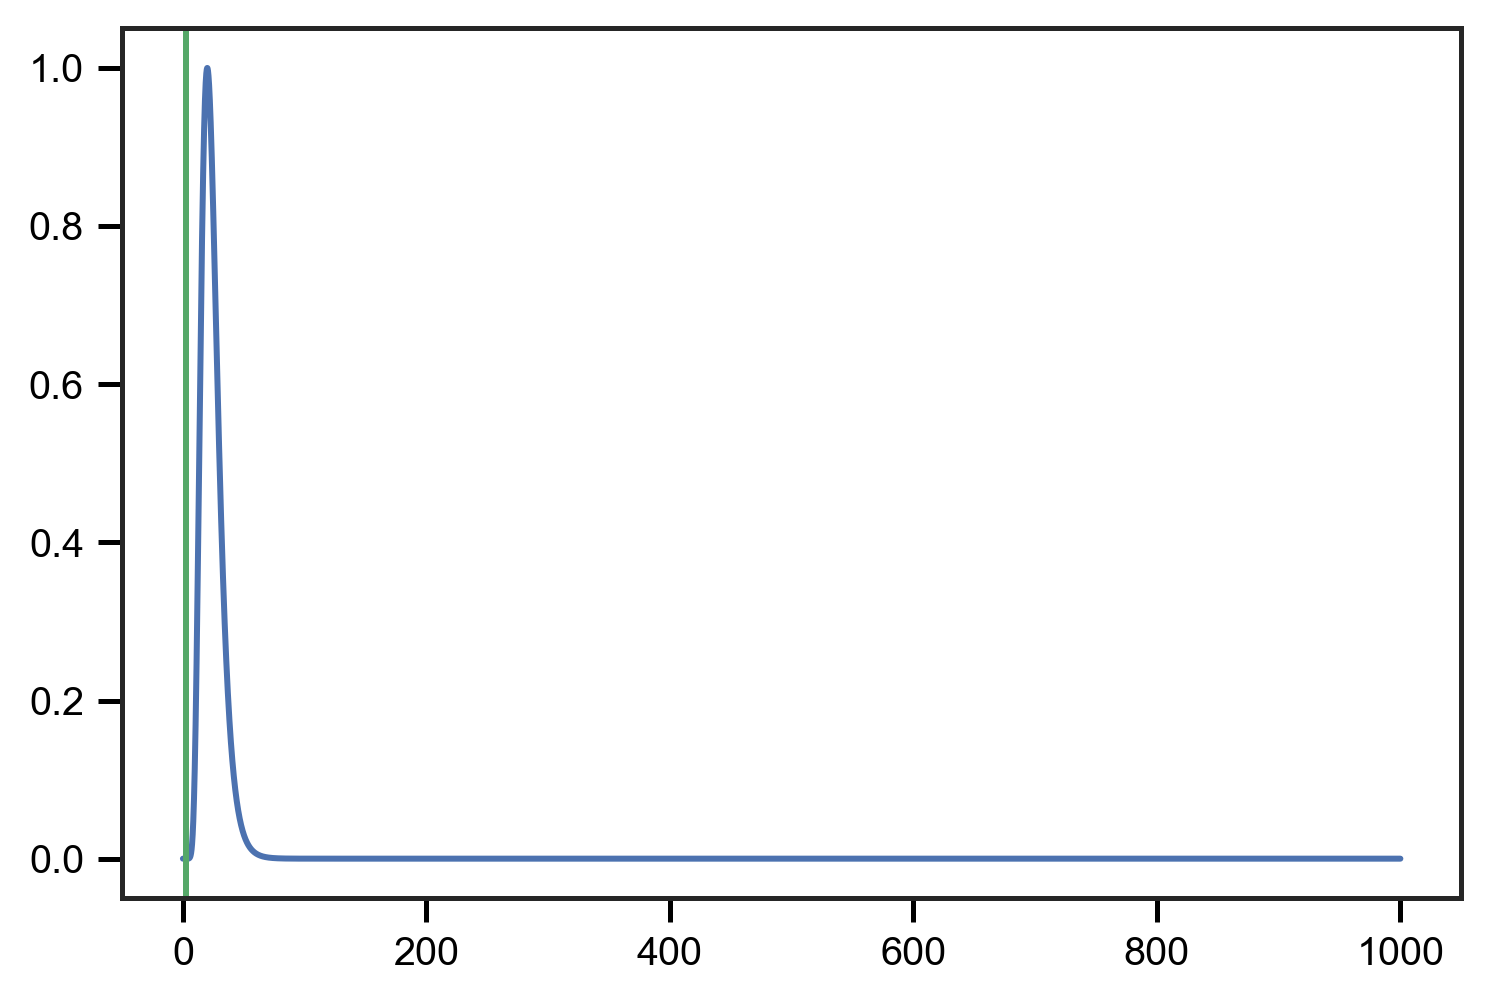

In [192]:
plt.plot(pred_x, pred_y)
plt.axvline(params_tmp_df['mode'].values[0], color='g')
plt.axhline(results_half_y, linestyle='--', color='g')
plt.axvline(results_half_x_min, linestyle='--', color='b')
plt.axvline(results_half_x_max, linestyle='--', color='k')
